# Comparing causal bandits and classical bandits algorithms: Simulation on a simple contengency task




## Preliminaries

In [2]:
import networkx as nx
from typing import Callable, Union, Tuple, Dict, List, Optional
import scipy.stats as st
import random
import numpy as np
import matplotlib.pyplot as plt
import pymdp
from tqdm import tqdm
import scipy.special as special
import warnings

In [3]:
variable : Union[str, None] = None
structural_function : Callable[[Tuple[int, Union[int, None]]], int] 
structural_equations: Dict[str, Tuple[Callable[[Tuple[int, Union[int, None]]], int], Dict[str, Union[int, None]]]] = {}


## Structural Causal Model 

Structural Causal Model is defined by $<V, F, U, P(U)>$ where $V$ (resp. $U$) is the set of endogenous (resp. exogenous) variables; $F$ is the set of functional equations and $P(U)$ is the probability distribution over the exogenous variables. 

Methods: 

- *get_sample*: outputs a single random variate from the internal SCM

- *draw*: draw the causal graph associated with the internal SCM

- *build_causal_graph*: outputs a causal graph based on the input variable list and structural equations.

In [4]:
class StructuralCausalModel: 
    """
    Structural Causal Model for Causal Bandit implementation.
    """

    def __init__(
        self,
        variables: List[str], 
        structural_equations: Dict[str, Tuple[Callable[[Tuple[int, Union[int, None]]], int], Dict[str, Union[int, None]]]]
             
    ):
        """
        Instantiate StructuralCausalModel class.

        Parameters
        ----------

        variables: list[variable:str]
            List containing the name of the variables. 

        structural_equations: dict[variable: (func, list[variable:str])]
            A dictionary containing the structural relations between variables
            and their values. 

        """

        self.variables = variables # list of variables
        self.values = { var: None for var in variables } # list of values taken by each variable
        self.structural_equations = structural_equations # functions for each variable
        self.causal_graph = self.build_causal_graph(variables, structural_equations) # a causal graph of the SCM

    def build_causal_graph(
        self, 
        variables: List[str],
        structural_equations: Dict[str, Tuple[Callable[[Tuple[int, Union[int, None]]], int], Dict[str, Union[int, None]]]]
        ) -> nx.DiGraph: 

        """
        Build a causal graph from variables list and structural equations. 

        Parameters
        ----------

        variables: list[variable]
        structural_equations: dict[variable, eqution]

        Returns
        ----------
        a DiGraph

        """

        output_graph = nx.DiGraph()
        nodes = variables
        edges = []
        
        for variable, equation in structural_equations.items(): 
            children_node = variable
            (function, vars) = equation
            
            for var, value in vars.items():
                parent_node = var
                edges.append((parent_node, children_node))

        output_graph.add_nodes_from(nodes)
        output_graph.add_edges_from(edges)

        return output_graph

    def graph(self):
        """ Draw the internal causal graph
        """
        nx.draw(self.causal_graph)

    def get_sample(self, set_values: Optional[Union[Dict[str, int],None]] = None) -> dict[str, Union[int, None]]:
        """
        Sample from SCM (could be manipulated through set_values).

        Parameters
        ----------
        set_values: dict[variable, int]
            The values fixed by intervention on variables.

        Returns
        ----------
        output_assignements : dict[variable, int] 

        """

        output_assignments = {var : None for var in self.variables}

        if set_values is not None: 
            
            # Assign values to manipulated variables
            for variable, value in set_values.items():
                output_assignments[variable] = value
                self.values[variable] = value
            
            # Assign values inside the structural_equations for variables which parents are manipulated variables
            for node in self.causal_graph.nodes:
                structural_function, parents = self.structural_equations[node]
                for parent in parents.keys():
                    if parent in set_values.keys():
                        parents[parent] = set_values[parent]

            # Assign values to remaining variables for output
            for node in nx.topological_sort(self.causal_graph):
                if node in set_values.keys():
                    pass
                else:
                    structural_function, parents = self.structural_equations[node]
                    output_assignments[node] = structural_function(parents)  

                    # when a value is assigned, make sure that it is also assigned in the structural_equations 
                    for node2 in self.causal_graph.nodes:
                        structural_function, parents = self.structural_equations[node2]
                        if node in parents.keys():
                            parents[node] = output_assignments[node]

        else:
            for node in nx.topological_sort(self.causal_graph):
                    structural_function, parents = self.structural_equations[node]
                    output_assignments[node] = structural_function(parents)  
                    
                    # when a value is assigned, make sure that it is also assigned in the structural_equations 
                    for node2 in self.causal_graph.nodes:
                        structural_function, parents = self.structural_equations[node2]
                        if node in parents.keys():
                            parents[node] = output_assignments[node]

        return output_assignments  

        """
        output_assignments = {}
    
        if set_values is not None: 
            
            # Assign values to manipulated variables
            for variable, value in set_values.items(): 
                output_assignments[variable] = value
                self.values[variable] = value
                
            # Assign values to manipulated parent variables
            for node in self.causal_graph.nodes: 
                structural_function, parents = self.structural_equations[node]
                for parent in parents.keys():
                    if parent in set_values.keys():
                        parents[parent] = set_values[parent]
                        self.values[parent] = set_values[parent]
        
            # Assign values to remaining variables 
            for node in nx.topological_sort(self.causal_graph): 
                if node in set_values.keys():
                    continue
                structural_function, parents = self.structural_equations[node]
                output_assignments[node] = structural_function(parents)
   
        else:
            # Assign values to all variables
            for node in nx.topological_sort(self.causal_graph): 
                structural_function, parents = self.structural_equations[node]
                output_assignments[node] = structural_function(parents) 

        # Assign values inside the equations
        for key, value in self.structural_equations.items(): 
            function, parent_di = value
            for key2, value2 in parent_di.items():
                parent_di[key2] = self.values[key2]
        
        return output_assignments
        """

## Environments



### Causal Bandit


A causal bandit is a bandit where variables are related using a Structural Causal Model. 

In [5]:
class CausalBandit:
    """
    Causal Bandit Class

    A causal bandit is a bandit where variables relations are represented on a causal graph/SCM.
    In this general case, variables are named X_i.
    """

    def __init__(
        self,
        structural_causal_model, 
        number_of_episode = 40,
    ):
        """
        Instantiate Causal Bandit Class

        Parameters
        ----------
        structural_causal_model: StructuralCausalModel instance
            the Structurral Causal Model of the Causal Bandit. 

        """
        
        self.scm = structural_causal_model
        self.payout_history: List[int] = []
        self.counter = 0
        self.episode = number_of_episode

    def get_sample(self, action):
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        arm, action_value = action

        # sample the scm with the manipulated variables "arm" set to "action_value"
        output = self.scm.get_sample(set_values={arm : action_value})

        # save the reward 
        self.payout_history.append(output)

        return output

    def step(self, action: Tuple[str, int]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[variable, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[variable, float]
        is_done: boolean
        """

        observation = self.get_sample(action)
        reward = observation["Y"]
        is_done = (self.counter >= self.episode)
        info = "Round n°{} of {}".format(self.counter, self.episode)

        self.counter += 1
        
        return (observation, reward, is_done, info)

### Bernoulli Causal Bandit 

A Bernoulli Causal bandit is a Bernoulli bandit with variables related using a SCM. 

In [6]:
class BernoulliCausalBandit(CausalBandit):
    """ Bernoulli Bandit with two choices: (X=0) or (X=1).   
    """
    
    def __init__(self, params, number_of_episode=40):
        
        """ Instantiate a Bernoulli Causal Bandit.

        Parameters
        ----------
        params: list[float]
            List of Bernoulli parameters.

            Z |  P(Y = 1 | X = 1, Z)    |   P(Y = 1 | X = 0, Z) | P(X | Z)
            --|-------------------------|-----------------------|----------
            0 |  params[0]              |   params[1]           |   params[5]
            1 |  params[2]              |   params[3]           |   params[6]



            Z ~ P(Z) = Bern(params[4]) 

        
        """

        self.counter = 0
        self.episode = number_of_episode
        self.params: Optional[List[float]] = params # list of Bernoulli parameters
        self.variables = ["X", "Y", "Z"] 
        self.history_best_payout = []
        self.regrets = []


        def best_arm(params):
            """ Identify the best arm for bernoulli static causal bandit. 
                pair ou impair et pas supérieur ou inférieur
            """
            index = np.argmax(params)
            output = np.mod(index, 2)

            return output

        self.best_arm = best_arm(params)
 
        def f_X(arg: dict[tuple[variable, int]]) -> int:
            """ function for X
                not used in practive because X is always manipulated
            """
            if arg["Z"] == 0:
                return st.bernoulli.rvs(self.params[5])
            else:
                return st.bernoulli.rvs(self.params[6])

        def f_Y(arg: dict[tuple[variable, int]]) -> int:
            """ function for Y
            """
            dict_values = {(0, 0): 1, (0, 1): 3, (1, 0): 0, (1, 1) : 2, (0, None): 1, (1, None): 3}
            
            return st.bernoulli.rvs(self.params[dict_values[(arg["X"], arg["Z"])]])

        def f_Z(arg: dict[tuple[variable, int]]) -> int:
            """ function for Z
            """
            
            return st.bernoulli.rvs(self.params[4])

        structural_equations = {
            "Z" : (f_Z, {}),
            "X" : (f_X, { "Z" : None}),
            "Y" : (f_Y, { "X" : None, "Z" : None}),
        }

        scm = StructuralCausalModel(self.variables, structural_equations)

        super().__init__(scm)

    def get_sample(self, action: float): 
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        if action != {}:
            arm, action_value = action
            output = self.scm.get_sample(set_values={arm : action_value})
        else:
            output = self.scm.get_sample({})




        self.regrets.append(1 - output["Y"])
        self.payout_history.append(output)

        
        return output

    def step(self, action: tuple[variable, float]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[variable, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[variable, float]
        done: boolean
        """

        observation = self.get_sample(action)
        reward = observation["Y"]
        is_done = (self.counter >= self.episode)
        info = "Round n°{}".format(self.counter)

        self.counter += 1
        
        return (observation, reward, is_done, info)

    def reset(self):
        """ Reset the observation and the counter of the environment
        """
        self.counter = 0
        self.regrets = []
        
        return {var : 0 for var in self.variables}

    def __name__(self):
        return 'BernoulliCausalBandit'

### Bernoulli Non-stationnary


In [7]:
class BernoulliChangingCausalBandit(CausalBandit):
    """ Bernoulli Bandit with two choices: (X=0) or (X=1).
        
    """
    
    def __init__(self, params, number_of_episode=40):
        
        """ Instantiate a Bernoulli Causal Bandit.

        Parameters
        ----------

        params: list[float]
            List of Bernoulli parameters.
            Z |  P(W|P,Z)
            --------------------
            0 |  params[0]
            1 |  params[2]

            Z ~ P(Z) = Bern(params[4])

            X ~ if Z = 0:
                    Bern(params[5])
                else:
                    Bern(params[6])
 

        """

        self.counter = 0
        self.episode = number_of_episode
        self.params: Optional[list[float]] = params
        self.variables = ["X", "Y", "Z"] 
        self.best_hist_payouts = []
        self.regrets = []
        


        def best_arm(params):
            """ Identify the best arm for bernoulli statitc causal bandit. 
                pair ou impair et pas supérieur ou inférieur
            """

            index = np.argmax(params)
            output = np.mod(index, 2)

            return output

        self.best_arm = best_arm(params)
 
        def f_X(arg: dict[tuple[variable, int]]) -> int:
            """ function for X
                not used in practive because X is always manipulated
            """
            if arg["Z"] == 0:
                return st.bernoulli.rvs(self.params[5])
            else:
                return st.bernoulli.rvs(self.params[6])           
        
        def f_Y(arg: dict[tuple[variable, int]]) -> int:
            """ function for Y
            """

            dict_values = {(0, 0): 1, (0, 1): 0, (1, 0): 3, (1, 1) : 2, (None, 0): 1, (None, 1): 3}
            
            return st.bernoulli.rvs(self.params[dict_values[(arg["Z"], arg["X"])]])


        def f_Z(arg: dict[tuple[variable, int]]) -> int:
            """ function for Z
            """
            return st.bernoulli.rvs(self.params[4])

        structural_equations = {
            "Z" : (f_Z, {}),
            "X" : (f_X, { "Z" : None}),
            "Y" : (f_Y, { "X" : None, "Z" : None}),
        }
        self.structural_equations = structural_equations

        scm = StructuralCausalModel(self.variables, structural_equations)

        super().__init__(scm)

    def get_sample(self, action): 
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        arm, action_value = action
        output = self.scm.get_sample(set_values={arm : action_value})

        best_output = 1

        self.regrets.append(best_output - output["Y"])
        self.payout_history.append(output)

        return output  

    def step(self, action: tuple[variable, float]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[variable, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[variable, float]
        done: boolean
        """
        observation = self.get_sample(action)
        reward = observation["Y"]
        is_done = (self.counter >= self.episode)
        info = "Round n°{}".format(self.counter)

        self.counter += 1
        
        return (observation, reward, is_done, info)

    def reset(self, switch:float=0.0):
        """ Reset the observation and the counter of the environment
        """
        self.counter = 0
        self.regrets = []


        def new_f_Z(arg: dict[tuple[variable, int]]) -> int:
            """ function for Z
            """
            return st.bernoulli.rvs(switch)

        self.structural_equations["Z"] = (new_f_Z, {})
        new_scm = StructuralCausalModel(self.variables, self.structural_equations)
        self.scm = new_scm

        return {var : 0 for var in self.variables }


    def __name__(self):
        return 'BernoulliChangingCausalBandit'

### Bernoulli Bandit

A Bernoulli bandit is a classical multi-armed bandit. Arms are only responsible for the outcome and not for other arms respsonse. 


In [8]:
class BernoulliBandit(CausalBandit):
    """ Bernoulli Bandit with two choices: (X=0) or (X=1).
    """
    
    def __init__(self, params=[0.3,0.6,0.6,0.8], episode=40):
        """ Instantiate a Bernoulli Causal Bandit.

        Parameters
        ----------

        params: list[float]
            List of Bernoulli parameters.
            X |  P(Y|X)
            --------------------
            0 |  params[0]
            1 |  params[1]

        """
        
        self.counter = 0
        self.episode = episode
        self.params: Optional[list[float]] = params
        self.variables = ["X", "Y"] 
        self.best_hist_payouts = []
        self.regrets = []

        def best_arm(params):
            """ Identify the best arm for bernoulli statitc causal bandit. 
            
            """
            index = np.argmax(params)
            output = np.mod(index, 2)
            return output

        self.best_arm = best_arm(params)
 
        def f_X(arg: dict[tuple[variable, int]]) -> int:
            """ function for X
            """
            output = st.bernoulli.rvs(0.5)
            return output
        
        def f_Y(arg: dict[tuple[variable, int]]) -> int:
            """ function for Y
            """
            output = 0
            x_value = arg["X"]
            if x_value == 0:
                output = st.bernoulli.rvs(self.params[0])
            else:
                output = st.bernoulli.rvs(self.params[1])
            return output

        structural_equations = {
            "X" : (f_X, {}),
            "Y" : (f_Y, { "X" : None}),
        }

        scm = StructuralCausalModel(self.variables, structural_equations)
        super().__init__(scm)

    def pull(self, i: float): 
        """
        Return the payout of a single pull of causal bandit i's arm. 

        Parameters
        ----------
        i: int
            Index of causal bandit to pull.

        Returns
        ----------
        int or None
        """
        output = self.scm.get_sample(set_values={"X" : i})
        #best_output = self.scm.sample(set_values = {"X" : self.best_arm})
        best_output = 1
        self.regrets.append(best_output - output["Y"])
        self.payout_history.append(output)
        return output  

    def step(self, action: tuple[variable, float]):
        """ Excecute action on env and returns reward, info, observation and done. 

        Parameters
        ----------
        action : tuple[variable, float]
            Action to execute.

        Returns
        ----------
        reward: float
        info: str
        observation: dict[variable, float]
        done: boolean
        """
        var, value = action 

        observation = self.pull(value)
        reward = observation["Y"]
        done = (self.counter >= self.episode)
        info = "Round n°{}".format(self.counter)
        self.counter += 1
        return (observation, reward, done, info)

    def reset(self):
        self.counter = 0
        observation = {}
        for var in self.variables:
            observation[var] = 0
        self.regrets = []
        return observation

    def __name__(self):
        return 'BernoulliBandit'

## Agents


### Random Agent

In [9]:
class Agent:
    """
    Generic class for agent model implementation.
    """

    def __init__(self, actions: list[variable, float]):
        """
        Instantiate a model for decision making on causal bandit envs.

        Parameters
        ----------
        actions : list[variable, float]
            list of possible actions. 
        
        """
        self.actions = actions

    
    def choose_action(self, observation):
        """ default is random sample. 
        """
        action = random.choices(self.actions)
        return action[0]


    def __name__(self):
        return 'RandomAgent'

### Thompson Sampling Agent

In [10]:
class TSAgent(Agent):
    """ Thompson Sampling
    """
    def __init__(self, actions: list[variable, float]):
        super().__init__(actions)
        self.K = len(actions)
        self.beta_params = [(1, 1) for k in range(self.K)]
        
    def choose_action(self, observation):

        # update beta params
        index = self.actions.index(("X", observation["X"]))
        alpha, beta = self.beta_params[index]
        self.beta_params[index] = (alpha + observation["Y"], beta + 1 - observation["Y"])

        # sample model
        theta_est = []
        for k in range(self.K):
            theta_est.append(st.beta.rvs(self.beta_params[k][0], self.beta_params[k][1]))

        # select action
        action_index = np.argmax(theta_est)
        return self.actions[action_index]

    def __name__(self):
        return 'TSAgent'

### Online Causal Thompson Sampling model

In [11]:
class OCTSAgent(Agent):
    """
    OCTS agent without causal graph knowledge
    """

    def __init__(self, actions: list[variable, float]):
        super().__init__(actions)
        self.K = len(self.actions)
        self.n_part = 4
        self.dirc = np.ones([self.n_part, self.K], dtype=int)
        self.beta = np.ones([self.n_part, 2], dtype=int)

    def choose_action(self, observation):
        """ Select action based on OCTS algorithm
            Note that X is always manipulated here
            so this does not work for an observational setting.
        """

        # update
        list_observation = [(key, value) for key, value in observation.items()]
        z = sum([2**i * list_observation[i][1] for i in range(len(list_observation)-1)])
        self.dirc[z, int(observation["X"])] += 1
        self.beta[z, 1 - int(observation["Y"])] += 1

        # sample        
        success_chance = np.zeros(self.K)

        for a in range(self.K):
            partition_prob = np.random.dirichlet(self.dirc[:,a]).reshape(-1,1)
            sample_prob = np.random.beta(self.beta[:, 0], self.beta[:, 1]).reshape(-1,1)
            success_chance[a] = sum(np.matmul(sample_prob.T, partition_prob))[0]
            
        # select action
        action_index = np.argmax(success_chance)
        
        return self.actions[action_index]


    def __name__(self):
        return 'OCTSAgent'

In [12]:
class OCTSAgent_with_graph(Agent):
    """
    OCTS agent without causal graph knowledge
    """

    def __init__(self, actions: list[variable, float], env):
        super().__init__(actions)
        self.K = len(self.actions)
        self.n_part = 4
        self.beta = np.ones([self.n_part, self.K], dtype=int)
        self.env = env

    def choose_action(self, observation):

        # update
        list_observation = [(key, value) for key, value in observation.items()]
        z = sum([2**i * list_observation[i][1] for i in range(len(list_observation)-1)])
        

        # sample        
        success_chance = np.zeros(self.K)

        for a in range(self.K):
            partition_prob = np.array([[st.bernoulli.rvs(self.env.params[4]), st.bernoulli.rvs(1-self.env.params[4])]]).reshape(-1, 1)
            sample_prob = np.random.beta(self.beta[:,0], self.beta[:, 1]).reshape(-1,1)
            success_chance[a] = sum(np.matmul(sample_prob, partition_prob.T))[0]
            print("success_chance:{}".format(success_chance))

        # select action
        action_index = np.argmax(success_chance)

        return self.actions[action_index]



    def __name__(self):
        return 'OCTSAgentWithGraph'

### Active Inference Truncated Agent

In [13]:
import scipy

class AIAgent(Agent):
    """ 
    """
    def __init__(self, actions: list[variable, float]):
        super().__init__(actions)
        self.K = len(actions)
        self.beta_params = [(1, 1) for k in range(self.K)]
        self.precision = 1.0
        
    def choose_action(self, observation, previous_action) : #, tmp = []):

        # update beta params
        var, value = previous_action
        index = self.actions.index((var, value)) # corriger erreur ici
        alpha_x, beta_x = self.beta_params[index]
        self.beta_params[index] = (alpha_x + observation["Y"], beta_x + 1 - observation["Y"])

        # compute approximate free energy
        est_eff = []
        tmp2 = []
        for k in range(self.K):
            alpha, beta = self.beta_params[k]
            nu = alpha + beta
            mu = alpha/nu
            est_eff.append(2*self.precision*mu + 1/(2*nu))
            tmp2.append(2*self.precision*mu + 1/(2*nu))

        #tmp.append(scipy.special.softmax(tmp2)) 
        #print("g:{}".format(est_eff))
        # select action
        action_index = np.argmax(est_eff)

        return self.actions[action_index] #, tmp



    def __name__(self):
        return 'AIAgent'



### Active Inference Agent

In [14]:
def triangle(x):
    output = None
    if x < 1/2:
        output = 2*x
    else:
        output = -2*x + 2
    
    return output

In [15]:
class AIBanditAgent(Agent):

    def __init__(self, actions: list[variable, float], param: float, precision:float = 0.1):
        super().__init__(actions)
        self.K = len(actions)
        self.beta_params = [(1, 1) for k in range(self.K)]  
        self.precision = precision
        self.rho = triangle(param)
    
    def choose_action(self, observation):

        # update beta params
        index = self.actions.index(("X", observation["X"]))
        alpha_x, beta_x = self.beta_params[index]
        self.beta_params[index] = (alpha_x + observation["Y"], beta_x + 1 - observation["Y"])
        
        # compute approximate free energy
        g = []
        
        for k in range(self.K):
            alpha, beta = self.beta_params[k]
            nu_1 = alpha + beta
            mu_1 = alpha/nu_1
            mu = mu_1 + self.rho*(0.5 - mu_1)

            g_a = -2*self.precision*(1-self.rho)*mu_1 + mu*np.log(mu) + (1-mu)*np.log(1 - mu) - \
                 (1 - self.rho)*(mu_1*special.digamma(alpha) + 1 - mu_1*special.digamma(beta)) + \
                    (1 - self.rho)*(special.digamma(nu_1)-1/nu_1) + 1
            g.append(g_a)
        
        # select action
        action_index = np.argmax(g)
        
        return self.actions[action_index]

## Simulations and Result

In [16]:
def f(name):
    if name == "AIAgent":
        print('ok')
    else:
        print("notok")

f("AIAgent")

ok


### Plots

In [17]:
def compute_probs(rewards, actions):

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

         

        # compute probability to win when the agent's play
        win_play = [((action[1] and reward)) for (action, reward) in zip(actions, rewards)]
        num_win_play = [np.sum(win_play[:i]) for i in range(len(win_play))]
        num_play = [np.sum([action[1] for action in actions[:i]]) for i in range(len(actions))]
        p_win_play = [win_play_t/play_total_t for (win_play_t, play_total_t) in zip(num_win_play, num_play)]

        # compute the probability to win when the agent doesn't play
        win_no_play = [int(not(action[1]) and reward) for (action, reward) in zip(actions, rewards)]
        num_win_no_play = [np.sum(win_no_play[:i]) for i in range(len(win_no_play))]
        num_no_play = [np.sum([int(not(action[1])) for action in actions[:i]]) for i in range(len(actions))]
        p_win_no_play = [win_no_play_t/no_play_t for (win_no_play_t, no_play_t) in zip(num_win_no_play, num_no_play)]

        # compute probability of play
        p_win_play = [(0.5 if np.isnan(p) else p) for p in p_win_play]
        p_win_no_play = [(0.5 if np.isnan(p) else p) for p in p_win_no_play]

        p_play = [num_play/i for (i, num_play) in enumerate(num_play)]

        return p_win_play, p_win_no_play, p_play

def plot_prob(agent_name: str, env_name: str, actions, switch: float=0.0, reset_agent: bool=True, change: bool = False):

    
    index = ["0.6", "0.4", "0.0", "-0.4"]
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    fig.suptitle(agent_name)

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(4):
            list_params = [[0.8, 0.2, 0.7, 0.3, switch],
                        [0.7, 0.3, 0.7, 0.3, switch],
                        [0.5, 0.5, 0.5, 0.5, switch],
                        [0.3, 0.7, 0.3, 0.7, switch]
                        ]
            
            if str(env_name).find('BernoulliCausalBandit') > 0:
                list_params = [[0.8, 0.2, 0.7, 0.3, 0.5, 0.5, switch],
                        [0.7, 0.3, 0.7, 0.3, 0.5, 0.5, switch],
                        [0.5, 0.5, 0.5, 0.5,0.5, 0.5, switch],
                        [0.3, 0.7, 0.3, 0.7,0.5, 0.5, switch]
                        ]
                        
            PARAMS = list_params[k]
            env = env_name(PARAMS)
            observation = {'X': 0, 'Y': 0, 'Z': 0}
        
            if not(reset_agent):
                agent = agent_name(actions)

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(100)):

                hist_observations = []
                hist_randag_rewards = []
                hist_randag_actions = []
                observation = env.reset()

                if reset_agent:
                    agent = agent_name(actions)

                previous_action = agent.actions[np.random.randint(2)]

                for t in range(40):
                    if ((t == 20) and change):
                        observation = env.reset()


                    if (str(agent).find("AIAgent") > 0 ):
                        action = agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = agent.choose_action(observation)
                        
                    observation, reward, done, info = env.step(action)
                    hist_randag_rewards.append(reward)
                    hist_randag_actions.append(action)
                    
                    #if done:
                    #     print("End of this episode.")
                    #    break
                    

                randag_pwp, randag_pwnp, p_play = compute_probs(hist_randag_rewards, hist_randag_actions)
                list_pwp.append(randag_pwp)
                list_pwnp.append(randag_pwnp)
                list_play.append(p_play)


            list_pwp = np.asarray(list_pwp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))

            x = np.arange(m) 
            
            axs[0].plot(x, pwp_means, label="P(win|play)={}".format(PARAMS[0]))
            axs[0].fill_between(x, pwp_means-pwp_stds, pwp_means+pwp_stds, alpha = 0.2, )
            axs[0].set_title('P(win|play)')
            axs[0].legend()

            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)
            
            x = np.arange(m)

            axs[1].plot(x, pwnp_means, label="P(win|not play)={}".format(PARAMS[1]))
            axs[1].fill_between(x, pwnp_means-pwnp_stds, pwnp_means+pwnp_stds, alpha = 0.2)
            axs[1].set_title('P(win|not play)')
            axs[1].legend()


            dp_means = np.nan_to_num(pwp_means - pwnp_means)
            dp_stds = np.nan_to_num(pwp_stds - pwnp_stds)

            axs[2].plot(x, dp_means,  label="dP={}".format(np.round(PARAMS[0]-PARAMS[1], 4)))
            axs[2].fill_between(x, dp_means-dp_stds, dp_means+dp_stds, alpha=0.2)
            axs[2].set_title("dP")
            axs[2].legend()

            list_play = np.asarray(list_play)
            _, m = np.shape(list_play)
            p_play_mean = np.asarray(([np.nanmean(list_play[:, j]) for j in range(m)]))
            p_play_std = np.asarray(([np.nanstd(list_play[:, j]) for j in range(m)]))
            mean = np.nanmean(p_play_mean)
            std = np.nanmean(p_play_std)
            axs[3].bar(index[k], (mean), yerr=std)
            axs[3].set_title("P(Play)")

        


Comparison between real dP and estimates

In [19]:
def plot_comparison_causal_estimates(actions, env, params):

    agents = [AIAgent, TSAgent, OCTSAgent, Agent]
    envs = [env(params) for i in range(len(agents))]
    
    fig, axs = plt.subplots(1, 1, figsize=(8,5))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(len(agents)):

            current_env = envs[k]

            observation = {'X': 0, 'Y': 0, 'Z': 0}

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(100)):

                current_agent = agents[k](actions)
                
                hist_observations = []
                hist_randag_rewards = []
                hist_randag_actions = []
                observation = current_env.reset()

                previous_action = current_agent.actions[np.random.randint(len(current_agent.actions))]

                for t in range(40):

                    if (str(current_agent).find("AIAgent") > 0 ):
                        action = current_agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = current_agent.choose_action(observation)
                        
                    observation, reward, done, info = current_env.step(action)
                    hist_randag_rewards.append(reward)
                    hist_randag_actions.append(action)
                    

                randag_pwp, randag_pwnp, p_play = compute_probs(hist_randag_rewards, hist_randag_actions)
                list_pwp.append(randag_pwp)
                list_pwnp.append(randag_pwnp)
                list_play.append(p_play)

            list_pwp = np.asarray(list_pwp)
            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))
           
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)

            dp_means = np.nan_to_num(pwp_means - pwnp_means)
            dp_stds = np.nan_to_num(pwp_stds - pwnp_stds)

            x = np.arange(m)

            axs.plot(x, dp_means,  label="{}".format(current_agent.__name__()))
            axs.fill_between(x, dp_means-dp_stds, dp_means+dp_stds, alpha=0.2)

            #if current_env.__name__() == "BernoulliCausalBandit"
            axs.plot(x, ((params[1]-params[0]))*np.ones(np.shape(x)))
            axs.set_title("dP")
            axs.legend()
    


100%|██████████| 100/100 [00:00<00:00, 433.04it/s]


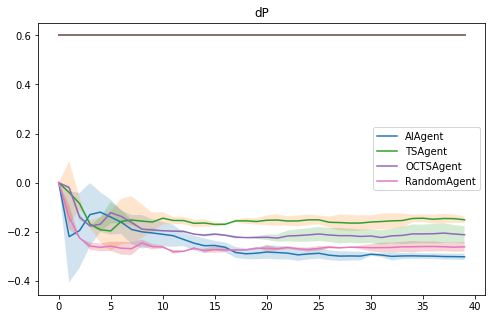

In [20]:
PARAMS = [0.2,0.8,0.3,0.7]
PARAMS = [0.2, 0.8, 0.3, 0.7, 0.5, 0.5, 0.5]

ACTIONS = [("X",0),("X",1)]
ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

#ENV = BernoulliCausalBandit
ENV = BernoulliCausalBandit
plot_comparison_causal_estimates(ACTIONS, ENV, PARAMS)

### Experiment 1 : Bernoulli standard bandit

100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


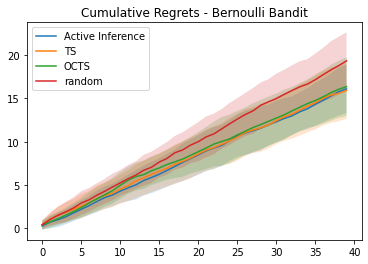

In [21]:
def plot_cumulative_regrets_bandit():
    PARAMS = [0.6,0.4]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, 1.0)]
    envs = [BernoulliBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(1000):
            observation = current_env.reset()
            for k in range(40):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
            
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')
        #plt.xticks(x)
    plt.legend(['Active Inference',  'TS', 'OCTS',  'random'])
    plt.title('Cumulative Regrets - Bernoulli Bandit')

plot_cumulative_regrets_bandit()


In [22]:
def get_hist_rewards_actions(agent, env):

    observation = env.reset()

    hist_observations = []
    hist_rewards = []
    hist_actions = []

    previous_action = agent.actions[np.random.randint(2)]

    for t in range(40):

        if ('AIAgent' in str(agent)):
            action = agent.choose_action(observation, previous_action)
            previous_action = action
        else:
            action = agent.choose_action(observation)
        observation, reward, done, info = env.step(action)

        hist_rewards.append(reward)
        hist_actions.append(action)
    

    return hist_rewards, hist_actions

In [23]:
PARAMS = [0.2,0.8,0.2,0.8, 1.0]
ACTIONS = [("X",0),("X",1)]

env = BernoulliBandit(PARAMS)

randagent = Agent(ACTIONS)
aiagent = AIAgent(ACTIONS)
aibanditgent = AIBanditAgent(ACTIONS, param = PARAMS[4])
tsagent = TSAgent(ACTIONS)
octsagent = OCTSAgent(ACTIONS)

hist_randag_rewards, hist_randag_actions = get_hist_rewards_actions(randagent, env)
hist_tsag_rewards, hist_tsag_actions = get_hist_rewards_actions(tsagent, env)
hist_octsag_rewards, hist_octsag_actions = get_hist_rewards_actions(octsagent, env)
hist_aiag_rewards, hist_aiag_actions = get_hist_rewards_actions(aiagent, env)


### Experiment 2 : Bernoulli Causal Bandit

100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


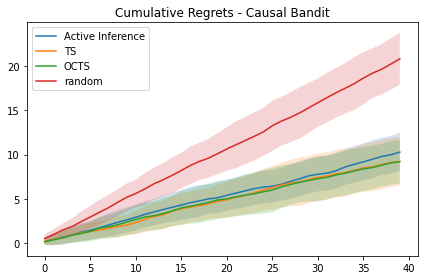

In [24]:
def plot_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(1000):
            observation = current_env.reset()
            for k in range(40):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend(['Active Inference',  'TS', 'OCTS',  'random', 'AI Bandit'])
    plt.title('Cumulative Regrets - Causal Bandit')
    plt.tight_layout()

plot_cumulative_regrets_causal_bandit()

In [25]:
randag_pwp, randag_pwnp, _ = compute_probs(hist_randag_rewards, hist_randag_actions)
tsag_pwp, tsag_pwnp, _ = compute_probs(hist_tsag_rewards, hist_tsag_actions)
octsag_pwp, octsag_pwnp, _ = compute_probs(hist_octsag_rewards, hist_octsag_actions)
aiag_pwp, aiag_pwnp, _ = compute_probs(hist_aiag_rewards, hist_aiag_actions)

Random agent

100%|██████████| 100/100 [00:00<00:00, 640.38it/s]


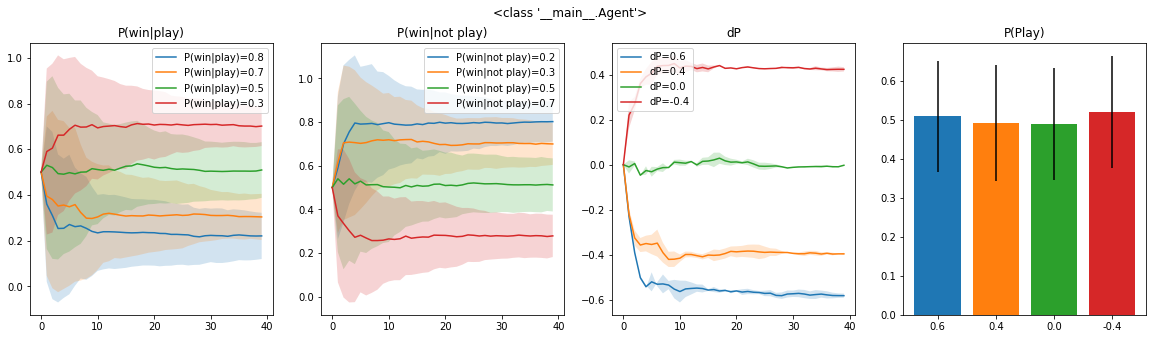

In [26]:
ACTIONS = [("X",0),("X",1)]
plot_prob(Agent, BernoulliBandit, ACTIONS,  switch=0.8, reset_agent=True)

TS Agent

100%|██████████| 100/100 [00:00<00:00, 339.32it/s]


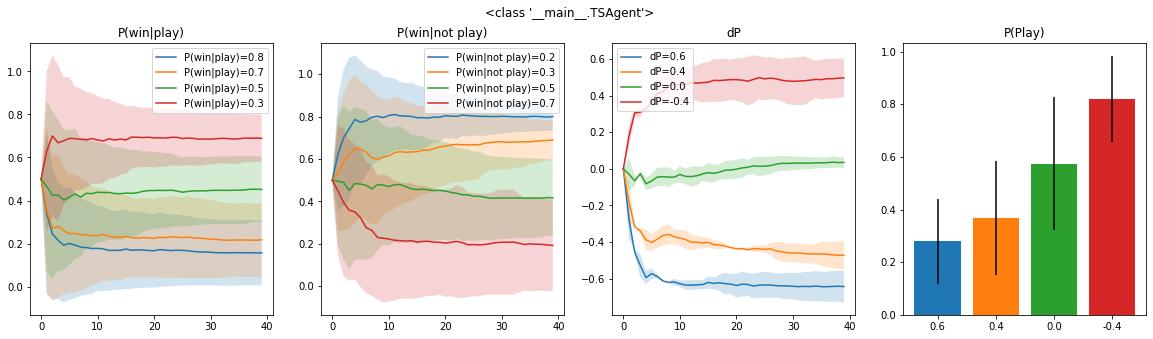

In [27]:
plot_prob(TSAgent, BernoulliBandit, actions= ACTIONS,  reset_agent=True, switch=0.9)

OCTS agent

100%|██████████| 100/100 [00:00<00:00, 284.69it/s]


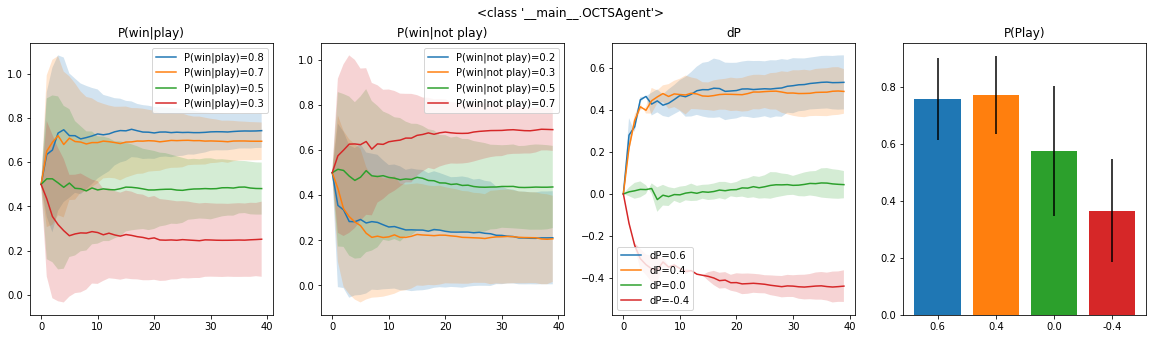

In [28]:
plot_prob(OCTSAgent, BernoulliCausalBandit, ACTIONS,  reset_agent=True, switch=0.4)

Active Inference agent

100%|██████████| 100/100 [00:00<00:00, 401.98it/s]


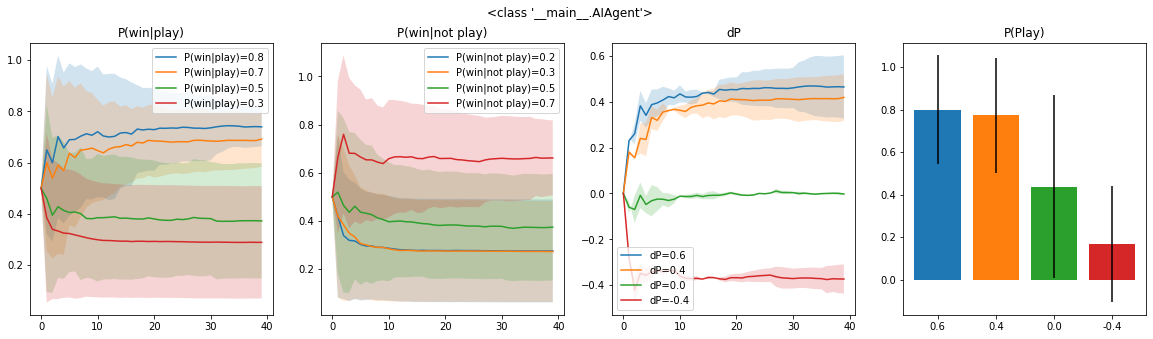

In [29]:
plot_prob(AIAgent, BernoulliCausalBandit, ACTIONS, reset_agent=True, switch=0.4)
#agent = AIBanditAgent(ACTIONS, PARAMS[4])

#### p(play) over time

In [30]:
def compute_probs_conf(arg_rewards, arg_actions):

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")

        actions = [action for action in arg_actions if action[0] == "X"]
        rewards = [reward for (action, reward) in zip(arg_actions, arg_rewards) if action[0] == "X"]

        # compute probability to win when the agent's play
        win_play = [((action[1] and reward)) for (action, reward) in zip(actions, rewards)]
        num_win_play = [np.sum(win_play[:i]) for i in range(len(win_play))]
        num_play = [np.sum([action[1] for action in actions[:i]]) for i in range(len(actions))]
        p_win_play = [win_play_t/play_total_t for (win_play_t, play_total_t) in zip(num_win_play, num_play)]

        # compute the probability to win when the agent doesn't play
        win_no_play = [int(not(action[1]) and reward) for (action, reward) in zip(actions, rewards)]
        num_win_no_play = [np.sum(win_no_play[:i]) for i in range(len(win_no_play))]
        num_no_play = [np.sum([int(not(action[1])) for action in actions[:i]]) for i in range(len(actions))]
        p_win_no_play = [win_no_play_t/no_play_t for (win_no_play_t, no_play_t) in zip(num_win_no_play, num_no_play)]

        # compute probability of play
        p_win_play = [(0.5 if np.isnan(p) else p) for p in p_win_play]
        p_win_no_play = [(0.5 if np.isnan(p) else p) for p in p_win_no_play]

        p_play = [num_play/i for (i, num_play) in enumerate(num_play)]

        return p_win_play, p_win_no_play, p_play




def compute_p_play(agent_name, reset_agent=True):

    list_params = [[0.2, 0.8, 0.3, 0.7, 0.6, 0.9, 0.1]]
                    #[0.7, 0.3, 0.3, 0.7, switch],
                    #[0.5, 0.5, 0.5, 0.5, switch],
                    #[0.3, 0.7, 0.7, 0.3, switch]]
    p_play_mean = []
    p_play_std = []
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

    for k in range(0,len(list_params)):

        with warnings.catch_warnings():

            warnings.simplefilter("ignore") 

            PARAMS = list_params[k]
            env = BernoulliCausalBandit(PARAMS)
            observation = env.reset()  

            if not(reset_agent):
                agent = agent_name(ACTIONS)

            list_play = []

            for i in tqdm(range(1000)):

                hist_observations = []
                hist_ag_rewards = []
                hist_ag_actions = []

                observation = env.reset()

                
                agent = agent_name(ACTIONS)
                    
                previous_action = agent.actions[np.random.randint(len(agent.actions))]


                for k in range(40):
                    action = agent.choose_action(observation)
                    observation, reward, done, info = env.step({})
                    hist_ag_rewards.append(reward)
                    hist_ag_actions.append(action) 
                    
                for k in range(40):    
                    action = agent.choose_action(observation)
                    observation, reward, done, info = env.step(action)
                    hist_ag_rewards.append(reward)
                    hist_ag_actions.append(action) 

                #for t in range(40):
                #    if (t == 20 ):
                #        observation = env.reset()

                #    if  agent.__name__() == "AIAgent":
                #        action = agent.choose_action(observation, previous_action)
                #        previous_action = action
                #    else:
                #        action = agent.choose_action(observation)
                #    observation, reward, done, info = env.step(action)

                #    hist_ag_rewards.append(reward)
                #    hist_ag_actions.append(action) 


                _, _, p_play = compute_probs(hist_ag_rewards, hist_ag_actions)
                
                list_play.append(p_play)

            list_play = np.asarray(list_play)
            _, m = np.shape(list_play)
            p_play_mean.append(np.asarray(([np.nanmean(list_play[:, j]) for j in range(m)])))
            p_play_std.append(np.asarray(([np.nanstd(list_play[:, j]) for j in range(m)])))

    return p_play_mean, p_play_std

In [31]:
print(compute_p_play(Agent))
p0, ps0 = compute_p_play(Agent)
p1, ps1 = compute_p_play(TSAgent)
p2, ps2 = compute_p_play(OCTSAgent)
#p3, ps3 = compute_p_play(AIAgent)

LIST_PARAMS = [0.2,0.3, 0.5, 0.7]

#fig, axs = plt.subplots(1, 4, figsize=(20,5))
#m = np.shape(p0)
#x = np.arange(m[1])


#for k in range(4):
#    for j in range(4):
#        axs[k].plot(x, locals()["p"+str(k)][j], label="P(win|not play)={}".format(LIST_PARAMS[j]))
#        axs[k].fill_between(x, locals()["p"+str(k)][j]-locals()["ps"+str(k)][j], locals()["p"+str(k)][j]+locals()["ps"+str(k)][j], alpha = 0.2)
#        axs[k].set_title('P(play)')
#        axs[k].legend()


100%|██████████| 1000/1000 [00:05<00:00, 181.98it/s]


([array([       nan, 0.486     , 0.492     , 0.50033333, 0.49925   ,
       0.5036    , 0.50183333, 0.50042857, 0.503125  , 0.503     ,
       0.5011    , 0.50145455, 0.5045    , 0.50369231, 0.50328571,
       0.50333333, 0.50375   , 0.50423529, 0.50394444, 0.50442105,
       0.50385   , 0.50338095, 0.50204545, 0.50243478, 0.50204167,
       0.50132   , 0.50119231, 0.50140741, 0.50160714, 0.502     ,
       0.50166667, 0.50267742, 0.5025    , 0.50239394, 0.50202941,
       0.5016    , 0.50130556, 0.50189189, 0.50194737, 0.50202564,
       0.50215   , 0.5024878 , 0.50269048, 0.50227907, 0.50204545,
       0.50188889, 0.50182609, 0.50217021, 0.50197917, 0.50208163,
       0.50232   , 0.50205882, 0.50219231, 0.50235849, 0.50255556,
       0.5022    , 0.50226786, 0.50212281, 0.50205172, 0.50208475,
       0.5021    , 0.50196721, 0.50195161, 0.50169841, 0.50195312,
       0.50209231, 0.5020303 , 0.50213433, 0.50195588, 0.50186957,
       0.50182857, 0.50207042, 0.50229167, 0.50245205, 0.502

100%|██████████| 1000/1000 [00:10<00:00, 99.57it/s]


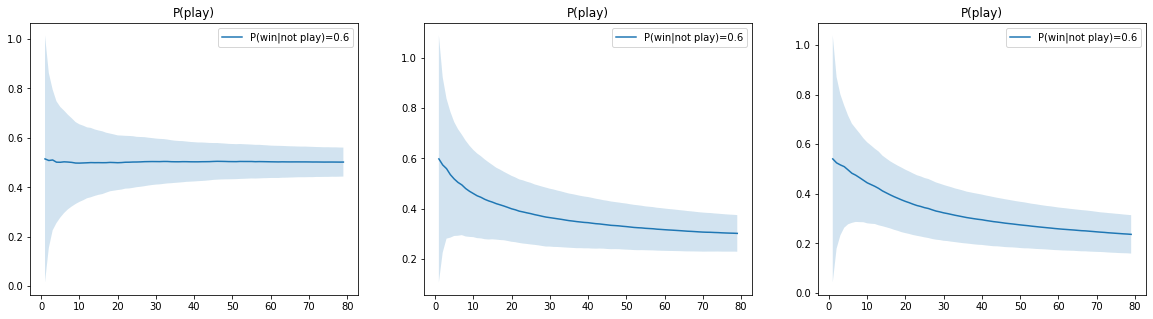

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(20,5))
m = np.shape(p0)
x = np.arange(m[1])


for k in range(3):
    axs[k].plot(x, locals()["p"+str(k)][0], label="P(win|not play)={}".format(0.6))
    axs[k].fill_between(x, locals()["p"+str(k)][0]-locals()["ps"+str(k)][0], locals()["p"+str(k)][0]+locals()["ps"+str(k)][0], alpha = 0.2)
    axs[k].set_title('P(play)')
    axs[k].legend()

### Experiment 3: Non-stationary Bernoulli Causal Bandit

100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


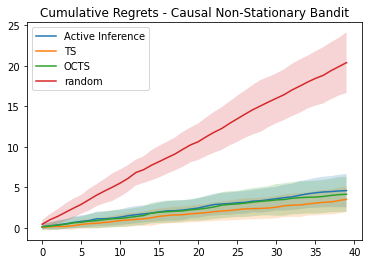

In [33]:
def plot_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5]
    ACTIONS = [("X",0),("X",1)]

    agents = [AIAgent(ACTIONS), TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliChangingCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(2)]

        for t in range(100):
            observation = current_env.reset()
            for k in range(40):
                if (i==0):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend(['Active Inference',  'TS', 'OCTS',  'random', 'AI Bandit'])
    plt.title('Cumulative Regrets - Causal Non-Stationary Bandit')

plot_cumulative_regrets_causal_bandit()

### Experiment 4 : Causal bandit with manipulable confounder

100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


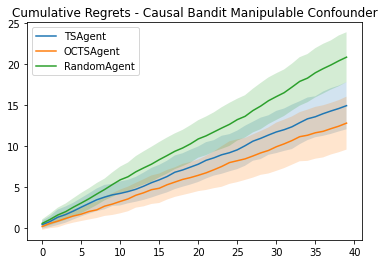

In [34]:
def plot_cumulative_regrets_causal_bandit():
    PARAMS = [0.9,0.1,0.6,0.4, 0.5, 0.5, 0.6]
    ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

    agents = [ TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(4)]

        for t in range(1000):
            observation = current_env.reset()
            for k in range(40):
                if (current_agent.__name__() == "AIAgent"):
                    action = current_agent.choose_action(observation, previous_action)
                    previous_action = action
                    
                else:
                    action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)
            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])
        x = np.arange(m)

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend([agent.__name__() for agent in agents])
    plt.title('Cumulative Regrets - Causal Bandit Manipulable Confounder')

plot_cumulative_regrets_causal_bandit()

### Experiment 5 : Observations


100%|██████████| 3/3 [00:10<00:00,  3.36s/it]


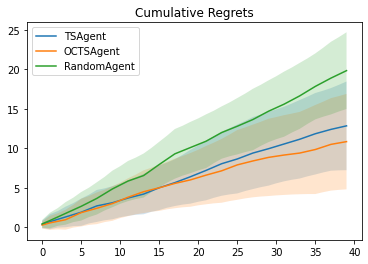

In [64]:
def plot_cumulative_regrets_causal_bandit_obs(PARAMS):

    #PARAMS = [0.7, 0.3, 0.4, 0.6, 0.6, 0.7, 0.3]
    ACTIONS = [("X",0), ("X",1), ("Z", 0), ("Z", 1)]

    agents = [ TSAgent(ACTIONS), OCTSAgent(ACTIONS), Agent(ACTIONS)]#, AIBanditAgent(ACTIONS, PARAMS[4])]
    envs = [BernoulliCausalBandit(PARAMS) for i in range(len(agents))]
    regrets = [[] for i in range(len(agents))]

    for i in tqdm(range(len(agents))): 
        current_agent = agents[i]
        current_env = envs[i]
        current_regret = regrets[i]

        previous_action = ACTIONS[np.random.randint(4)]

        for t in range(100):
            observation = current_env.reset()

            for k in range(20):
                action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step({})

            current_regret.append(current_env.regrets)
                
            for k in range(20):    
                action = current_agent.choose_action(observation)
                observation, reward, done, info = current_env.step(action)

            current_regret.append(current_env.regrets)
        
        current_cumul_reg = np.cumsum(current_regret, axis=0)
        _,m = np.shape(current_cumul_reg)
        x = np.arange(m)

        means = np.asarray([np.mean(current_cumul_reg[j, :]) for j in range(m)])
        stds = np.asarray([np.std(current_cumul_reg[j, :]) for j in range(m)])

        plt.plot(x, means)
        plt.fill_between(x, means - stds, means + stds, alpha = 0.2, label='_nolegend_')

    plt.legend([agent.__name__() for agent in agents])
    plt.title('Cumulative Regrets')


p = 0.9
q = 0.8

plot_cumulative_regrets_causal_bandit_obs(PARAMS = [p, 1-p, q, 1-q, 0.3, 0.7, 0.3])



 70%|███████   | 7/10 [13:19<05:42, 114.17s/it]


KeyboardInterrupt: 

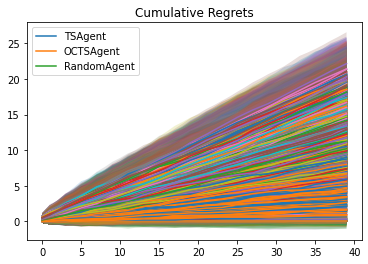

In [58]:
for i in tqdm(range(10)):
    for k in range(10):
        for l in range(10):
            PARAMS = [i/10, 1-i/10, l/10, 1-l/10, k/10, i/10, l/10]
            plot_cumulative_regrets_causal_bandit_obs(PARAMS)

In [111]:
def plot_comparison_causal_estimates_obs(actions, env, params):

    agents = [TSAgent, OCTSAgent, Agent]
    envs = [env(params) for i in range(len(agents))]
    
    fig, axs = plt.subplots(1, 1, figsize=(8,5))

    with warnings.catch_warnings():

        warnings.simplefilter("ignore")   

        for k in range(len(agents)):

            current_env = envs[k]

            observation = {'X': 0, 'Y': 0, 'Z': 0}

            list_pwp = []
            list_pwnp = []
            list_play = []

            for i in tqdm(range(1000)):

                current_agent = agents[k](actions)
                
                hist_observations = []
                hist_rewards = []
                hist_actions = []
                observation = current_env.reset()

                previous_action = current_agent.actions[np.random.randint(len(current_agent.actions))]

                #for t in range(20):
                #    action = current_agent.choose_action(observation)                        
                #    observation, reward, done, info = current_env.step({})
                #    hist_rewards.append(reward)
                #    hist_actions.append(action) 

                for t in range(40):

                    if (str(current_agent).find("AIAgent") > 0 ):
                        action = current_agent.choose_action(observation, previous_action)
                        previous_action = action
                    else:
                        action = current_agent.choose_action(observation)
                        
                    observation, reward, done, info = current_env.step(action)
                    hist_rewards.append(reward)
                    hist_actions.append(action)
                    

                pwp, pwnp, p_play = compute_probs(hist_rewards, hist_actions)
                list_pwp.append(pwp)
                list_pwnp.append(pwnp)
                list_play.append(p_play)

            list_pwp = np.asarray(list_pwp)
            list_pwnp = np.asarray(list_pwnp)
            _, m = np.shape(list_pwnp)
            _, m = np.shape(list_pwp)
            
            pwp_means = np.asarray(([np.nanmean(list_pwp[:,j]) for j in range(m)]))
            pwp_stds = np.asarray(([np.nanstd(list_pwp[:,j]) for j in range(m)]))
           
            pwnp_means = np.asarray(([np.nanmean(list_pwnp[:,j]) for j in range(m)]))
            pwnp_stds = np.asarray(([np.nanstd(list_pwnp[:,j]) for j in range(m)]))

            pwnp_means = np.nan_to_num(pwnp_means)
            pwnp_stds = np.nan_to_num(pwnp_stds)

            dp_means = np.nan_to_num(pwp_means - pwnp_means)
            dp_stds = np.nan_to_num(pwp_stds - pwnp_stds)

            x = np.arange(m)

            axs.plot(x, dp_means,  label="{}".format(current_agent.__name__()))
            axs.fill_between(x, dp_means-dp_stds, dp_means+dp_stds, alpha=0.2)


            #axs.plot(x, ((params[1]-params[0]))*np.ones(np.shape(x)))
            axs.plot(x, (0.0*np.ones(np.shape(x))))

            axs.set_title("dP")
            axs.legend()
    


100%|██████████| 1000/1000 [00:02<00:00, 494.85it/s]


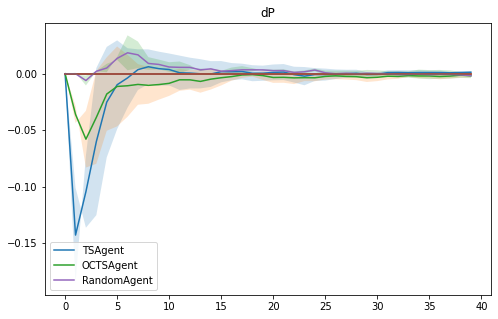

In [113]:
#PARAMS = [0.2,0.8,0.3,0.7]
PARAMS = [0.1, 0.1, 0.9, 0.9, 0.6, 0.7, 0.5]


ACTIONS = [("X",0),("X",1)]
#ACTIONS = [("X",0),("X",1), ("Z", 0), ("Z", 1)]

ENV = BernoulliBandit
#ENV = BernoulliBandit
plot_comparison_causal_estimates_obs(ACTIONS, ENV, PARAMS)